# BaseLine Transformer model

Caution: This is not a usual use case of Transformer.

Transformer developed by Google usually use Embeddeding Layer to represents a target such as a word.

In this model, I use OHLC as a state vector though we can take same approch for finance data.
As d_model is very low, this would be a base line of Transformer.

Parameters:
- Input:  ohlc_df.iloc[index] while observation length
- Target: ohlc_df.iloc[index+observation_length] while prediction length

## Prepare Data

Since we shouldn't expose data obtained from other service, csv is not committed to this repository.
Please preprare your data and load it.

In [1]:
import os
ohlc_column = ['open','high','low','close']
file_path = os.path.abspath('../../Data/mt5_USDJPY_min30.csv')

In [2]:
import pandas as pd
df = pd.read_csv(file_path)
df

,time,open,high,low,close,tick_volume,spread,real_volume
0,2014-07-07 08:30:00,102.086,102.122,102.081,102.102,738,3,0
1,2014-07-07 09:00:00,102.102,102.146,102.098,102.113,1036,3,0
2,2014-07-07 09:30:00,102.113,102.115,102.042,102.044,865,3,0
3,2014-07-07 10:00:00,102.047,102.052,102.005,102.019,983,3,0
4,2014-07-07 10:30:00,102.017,102.025,101.918,101.941,1328,3,0
...,...,...,...,...,...,...,...,...
100715,2022-08-12 21:30:00,133.461,133.506,133.439,133.484,1125,3,0
100716,2022-08-12 22:00:00,133.484,133.530,133.437,133.475,1277,3,0
100717,2022-08-12 22:30:00,133.475,133.486,133.433,133.483,1506,3,0
100718,2022-08-12 23:00:00,133.484,133.536,133.465,133.521,1038,3,0


## Basic Dataset Definition

In [3]:
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from torch.utils.data import DataLoader
from tqdm import tqdm

In [4]:
import sys

module_path = os.path.abspath("../..")
sys.path.append(module_path)

from Dataset.transformer import FeatureDataset
import fprocess

## Define Model

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000, dropout=0.05):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(-2)
        #pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, src, tgt):
        src_pos = src.size(0)
        tgt_pos = src_pos + tgt.size(0) - 1
        return self.dropout(src + self.pe[:src_pos, :]), self.dropout(tgt + self.pe[src_pos-1:tgt_pos, :])

In [6]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        feature_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.positional_encoding = PositionalEncoding(feature_size, dropout=dropout)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

    def forward(
        self, src: Tensor, tgt: Tensor, mask_tgt: Tensor,
        mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        
        src, tgt = self.positional_encoding(src, tgt)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return outs

## Define Training Methods

In [7]:
def train(model, ds, optimizer, criterion, batch_size, device):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index, batch_size)):
        if end_index - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, tgt=input_tgt,  mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [8]:
def evaluate(model, ds, criterion, batch_size, device):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds), batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)

        logits = model(
            src=src, tgt=input_tgt, mask_tgt=mask_tgt,
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

## Training

In [9]:
ohlc_column = ['open','high','low','close']
#volume_column = ["tick_volume"]
#columns = ohlc_column+volume_column
columns = ohlc_column

log_p = fprocess.LogPreProcess(columns=ohlc_column)
diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
ohlc_pre_process = [log_p, diff_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "finance_basic_transfomer"
model_version = "1"

#Dataset parameters
batch_size = 64
observation_length = 30
prediction_length = 10

ds = FeatureDataset(df, columns, processes=processes,
             observation_length=observation_length, prediction_length=prediction_length)

In [11]:
# check outputs represents (data_length, chunk_size, feature_size)
ds.train()
for index in range(0, len(ds)-16, 16):
    src, tgt = ds[index: index+16]
    continue
print(src.shape, tgt.shape)

torch.Size([30, 16, 4]) torch.Size([11, 16, 4])


In [12]:
feature_size = 4

# Hyper parameters
nhead = 1
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.01

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

In [13]:
lr = 0.00005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [14]:
epoch = 500
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,
        batch_size=batch_size, device=device
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|█████████▉| 1101/1102 [08:27<00:00,  2.17it/s]


[1/500] train loss: 0.8091842407, valid loss: 0.7285565459  27s] count: 0, **


100%|█████████▉| 1101/1102 [08:24<00:00,  2.18it/s]


[2/500] train loss: 0.6581299651, valid loss: 0.5877457113  24s] count: 0, **


100%|█████████▉| 1101/1102 [08:06<00:00,  2.26it/s]


[3/500] train loss: 0.5217742690, valid loss: 0.4579240387  6s] count: 0, **


100%|█████████▉| 1101/1102 [08:02<00:00,  2.28it/s]


[4/500] train loss: 0.4014476198, valid loss: 0.3468646330  3s] count: 0, **


100%|█████████▉| 1101/1102 [07:17<00:00,  2.52it/s]


[5/500] train loss: 0.2989568525, valid loss: 0.2529477035  17s] count: 0, **


100%|█████████▉| 1101/1102 [07:55<00:00,  2.32it/s]


[6/500] train loss: 0.2132053447, valid loss: 0.1752312703  56s] count: 0, **


100%|█████████▉| 1101/1102 [07:52<00:00,  2.33it/s]


[7/500] train loss: 0.1437016469, valid loss: 0.1141124351  53s] count: 0, **


100%|█████████▉| 1101/1102 [07:28<00:00,  2.45it/s]


[8/500] train loss: 0.0909118540, valid loss: 0.0694108857  29s] count: 0, **


100%|█████████▉| 1101/1102 [07:29<00:00,  2.45it/s]


[9/500] train loss: 0.0535441477, valid loss: 0.0389217476  29s] count: 0, **


100%|█████████▉| 1101/1102 [07:28<00:00,  2.46it/s]


[10/500] train loss: 0.0289269585, valid loss: 0.0196340735  28s] count: 0, **


100%|█████████▉| 1101/1102 [07:31<00:00,  2.44it/s]


[11/500] train loss: 0.0139584954, valid loss: 0.0084989027  32s] count: 0, **


100%|█████████▉| 1101/1102 [07:27<00:00,  2.46it/s]


[12/500] train loss: 0.0058990128, valid loss: 0.0031312718  28s] count: 0, **


100%|█████████▉| 1101/1102 [07:08<00:00,  2.57it/s]


[13/500] train loss: 0.0025372335, valid loss: 0.0013737952  9s] count: 0, **


100%|█████████▉| 1101/1102 [07:38<00:00,  2.40it/s]


[14/500] train loss: 0.0016838942, valid loss: 0.0011008772  38s] count: 0, **


100%|█████████▉| 1101/1102 [07:54<00:00,  2.32it/s]


[15/500] train loss: 0.0015938807, valid loss: 0.0010887788  55s] count: 0, **


100%|█████████▉| 1101/1102 [07:44<00:00,  2.37it/s]


[16/500] train loss: 0.0015893154, valid loss: 0.0010885016  45s] count: 0, **


100%|█████████▉| 1101/1102 [06:54<00:00,  2.66it/s]


[17/500] train loss: 0.0015879614, valid loss: 0.0010887920  54s] count: 0, 


100%|█████████▉| 1101/1102 [06:24<00:00,  2.86it/s]


[18/500] train loss: 0.0015872501, valid loss: 0.0010888775  25s] count: 1, 


100%|█████████▉| 1101/1102 [06:25<00:00,  2.86it/s]


[19/500] train loss: 0.0015866232, valid loss: 0.0010888970  26s] count: 2, 


100%|█████████▉| 1101/1102 [06:56<00:00,  2.64it/s]


[20/500] train loss: 0.0015861536, valid loss: 0.0010887473  57s] count: 3, 


100%|█████████▉| 1101/1102 [07:52<00:00,  2.33it/s]


[21/500] train loss: 0.0015858036, valid loss: 0.0010887539  52s] count: 4, 


100%|█████████▉| 1101/1102 [07:45<00:00,  2.37it/s]


[22/500] train loss: 0.0015856441, valid loss: 0.0010887138  45s] count: 5, 


100%|█████████▉| 1101/1102 [07:37<00:00,  2.41it/s]


[23/500] train loss: 0.0015853862, valid loss: 0.0010885514  37s] count: 6, 


100%|█████████▉| 1101/1102 [07:24<00:00,  2.48it/s]


[24/500] train loss: 0.0015851819, valid loss: 0.0010885444  24s] count: 7, 


100%|█████████▉| 1101/1102 [07:24<00:00,  2.48it/s]


[25/500] train loss: 0.0015850298, valid loss: 0.0010886731  25s] count: 8, 


100%|█████████▉| 1101/1102 [07:23<00:00,  2.48it/s]


[26/500] train loss: 0.0015849204, valid loss: 0.0010885901  24s] count: 9, 


100%|█████████▉| 1101/1102 [07:34<00:00,  2.42it/s]


[27/500] train loss: 0.0015848255, valid loss: 0.0010885851  35s] count: 10, 


In [38]:
torch.save(best_model.state_dict(), f'./{model_name}_v{model_version}.torch')

## Validation

In [14]:
model_version = 1
model.load_state_dict(torch.load(f'./{model_name}_v{model_version}.torch'))

<All keys matched successfully>

In [15]:
def prediction(inputs):

    preds = torch.zeros(1, inputs.size(1), feature_size, device=device)
    preds[0, :, :] = inputs[-1,:, :]
    while preds.size(0) <= prediction_length:
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(preds.size(0)).to(device)
        out = model(src=inputs, tgt=preds,  mask_tgt=tgt_mask)
        preds = torch.cat([preds, out[-1:]], dim=0)
    return preds

In [16]:
src, tgt = ds[:16]

In [70]:
tgt_values = tgt.cpu().detach().numpy()
tgt_values.shape

(11, 16, 4)

In [71]:
src_values = src.cpu().detach().numpy()

In [72]:
r_data = ds.revert(src_values, [index for index in range(0, 16)], is_tgt=False)

In [73]:
# reverted open values
r_data[:, 0, 0]

array([106.59    , 106.520996, 106.520996, 106.54599 , 106.47799 ,
       106.471985, 106.43199 , 106.42899 , 106.383995, 106.383995,
       106.352   , 106.32399 , 106.104996, 106.255974, 106.168015,
       106.222   , 106.01402 , 106.10298 , 105.99102 , 106.06099 ,
       106.081985, 106.09301 , 106.22402 , 106.20001 , 106.223   ,
       106.30302 , 106.205986, 106.29601 , 106.246   , 106.22897 ],
      dtype=float32)

In [66]:
index = ds.get_actual_index([0])[0]
df[ohlc_column].iloc[index:index+30]

,open,high,low,close
63087,106.590,106.623,106.500,106.520
63088,106.521,106.588,106.517,106.521
63089,106.521,106.552,106.484,106.546
63090,106.546,106.546,106.461,106.478
63091,106.478,106.495,106.443,106.473
63092,106.472,106.473,106.389,106.432
63093,106.432,106.463,106.428,106.428
63094,106.429,106.457,106.374,106.384
63095,106.384,106.447,106.365,106.382
63096,106.384,106.415,106.350,106.352


In [74]:
tgt_values = tgt.cpu().detach().numpy()

In [75]:
tgt_r_data = ds.revert(tgt_values, [index for index in range(0, 16)], is_tgt=True)

In [76]:
# reverted open values
tgt_r_data[:, 0, 0]

array([106.22897 , 106.25102 , 106.26399 , 106.27302 , 106.205986,
       106.136986, 105.87499 , 106.07202 , 105.82498 , 105.70298 ,
       105.68801 ], dtype=float32)

In [77]:
index = ds.get_actual_index([0])[0]
df[ohlc_column].iloc[index+29:index+40]

,open,high,low,close
63116,106.229,106.281,106.219,106.251
63117,106.251,106.285,106.218,106.263
63118,106.264,106.284,106.248,106.273
63119,106.273,106.283,106.207,106.208
63120,106.206,106.241,106.089,106.135
63121,106.137,106.143,105.833,105.875
63122,105.875,106.069,105.701,106.069
63123,106.072,106.101,105.806,105.825
63124,105.825,105.864,105.650,105.703
63125,105.703,105.881,105.589,105.688


In [35]:
ds.eval()
model.eval()

split_factor = 300
split_index = int(len(ds)/split_factor)

for factor in range(0, split_factor):
    if factor == split_factor-1:
        val_inp, val_ans = ds[split_index * factor :]
        ndx = slice(split_index * factor, len(ds))
    else:
        val_inp, val_ans = ds[split_index * factor : split_index * (factor+1)]
        ndx = slice(split_index * factor, split_index * (factor+1))
        
    preds = prediction(val_inp)
    pre_values = preds.cpu().detach().numpy()
    
    ohlc = ds.revert(pre_values, ndx, True)
    
    if factor == 0:
        ohlc_pre = ohlc
    else:
        ohlc_pre = np.append(ohlc_pre, ohlc, axis=1)
    
    ans_values = val_ans.cpu().detach().numpy()
    
    temp_ohlc = ds.revert(ans_values, ndx, True)
    
    if factor == 0:
        ohlc_ans = temp_ohlc
    else:
        ohlc_ans = np.append(ohlc_ans, temp_ohlc, axis=1)

In [18]:
print(ohlc_pre.shape, ohlc_ans.shape)

(11, 30164, 4) (11, 30164, 4)


[]

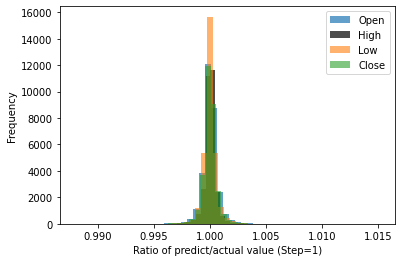

In [19]:
step=1
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

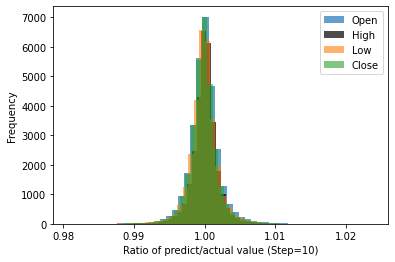

In [20]:
step=10
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [21]:
print("==============Mean============")
print("Open", np.mean(ohlc_pre[:, :, 0]/ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[:, :, 1]/ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[:, :, 2]/ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[:, :, 3]/ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[:, :, 0]/ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[:, :, 1]/ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[:, :, 2]/ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[:, :, 3]/ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [1.         0.99999611 0.99999215 0.99998821 0.99998424 0.99998041
 0.99997657 0.99997282 0.99996899 0.9999652  0.99996152]
High [1.         1.00000855 1.00001708 1.00002559 1.00003419 1.00004284
 1.00005155 1.00006022 1.00006889 1.00007765 1.00008645]
Low [1.         0.99999144 0.99998292 0.99997434 0.99996571 0.99995719
 0.99994872 0.99994026 0.99993189 0.99992366 0.99991532]
Close [1.         0.99998693 0.99997385 0.99996078 0.99994782 0.99993487
 0.99992198 0.99990903 0.99989611 0.99988325 0.99987045]
==============Var============
Open [0.00000000e+00 5.40798553e-07 1.05561586e-06 1.59424361e-06
 2.11457189e-06 2.64702209e-06 3.18154737e-06 3.73484919e-06
 4.27708423e-06 4.81534493e-06 5.35700973e-06]
High [0.00000000e+00 2.89565526e-07 6.51417274e-07 1.01478101e-06
 1.37265861e-06 1.73481728e-06 2.09681876e-06 2.46109037e-06
 2.82339027e-06 3.18788276e-06 3.54613860e-06]
Low [0.00000000e+00 3.94314927e-07 8.61170238e-07 1.32628495e-06
 1.7735172

[]

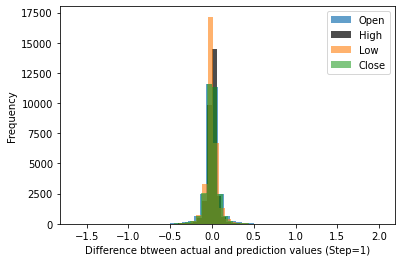

In [22]:
step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

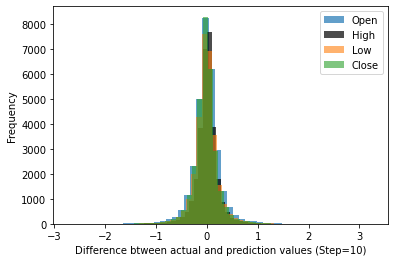

In [23]:
step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [24]:
np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [ 0.      -0.00053 -0.00107 -0.00161 -0.00216 -0.0027  -0.00324 -0.00378
 -0.00433 -0.00488 -0.00542]
High [0.      0.0009  0.00178 0.00266 0.00355 0.00443 0.00531 0.00619 0.00706
 0.00793 0.0088 ]
Low [ 0.      -0.00104 -0.00207 -0.00311 -0.00416 -0.00519 -0.00622 -0.00725
 -0.00827 -0.00927 -0.01028]
Close [ 0.      -0.00155 -0.00309 -0.00464 -0.00617 -0.00771 -0.00923 -0.01077
 -0.0123  -0.01382 -0.01534]
==============Var============
Open [0.      0.00759 0.01492 0.02268 0.03033 0.03827 0.04636 0.05483 0.06329
 0.07176 0.08044]
High [0.      0.00398 0.00886 0.01373 0.01846 0.0232  0.02788 0.03252 0.03709
 0.04164 0.04605]
Low [0.      0.00551 0.01197 0.01842 0.02461 0.03077 0.037   0.04333 0.04965
 0.05594 0.06212]
Close [0.      0.00609 0.0119  0.01806 0.02398 0.03011 0.03621 0.04247 0.04871
 0.0549  0.06111]


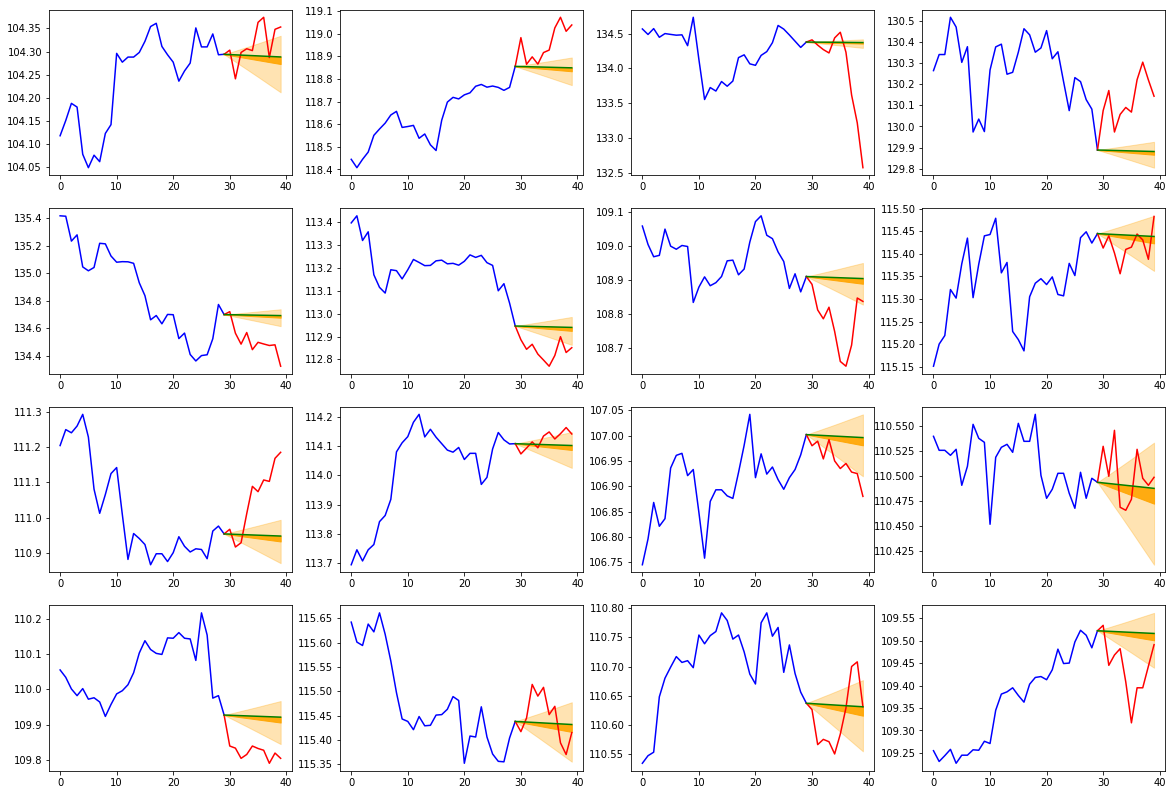

In [36]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)
close_var = np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)

total_length = observation_length + prediction_length
x = np.arange(total_length)



for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i)
    original_ohlc = df[ohlc_column[3]].iloc[index: index + observation_length]
    pred_value = ohlc_pre[:, i, 3]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length -1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length -1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length-1:], ohlc_ans[:, i, 3], color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
plt.show()

# BaseLine Transformer model with Weekly Time Position

Above results seems that predictions didn't learn the position. Not sure if that caused by different scale difference or lack of features.
Next model investigate it by changing positioning encoder from sin/cos of vector position to weekky hour position.
For example, if the steps is observed on [Monday 23:00, Monday 23:30, Thuesday 00:00, Thuesday 00:00], makes it as [47, 48, 49, 50] to represents the position of the step in the week. Then convert it to Embedded vector to add it with src and tgt.

## Prepare Data

In [1]:
import os
import pandas as pd


ohlc_column = ['open','high','low','close']
file_path = os.path.abspath('../../Data/mt5_USDJPY_min30.csv')
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

In [2]:
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
import sys

module_path = os.path.abspath("../..")
sys.path.append(module_path)

from Dataset.transformer import TimeFeatureDataset
from fprocess import fprocess

## Define Model

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, time_size, d_model):
        super().__init__()
        self.pe = nn.Embedding(time_size, d_model)

    def forward(self,time_ids):
        position = self.pe(time_ids)
        return position

In [5]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        feature_size: int, time_size:int =  24*7*2,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.positional_encoding = PositionalEncoding(time_size=time_size, d_model=feature_size)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

    def forward(
        self,
        src: Tensor, src_time: Tensor,
        tgt: Tensor, tgt_time: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        
        src_time = self.positional_encoding(src_time)
        src = torch.add(src, src_time)
        tgt_time = self.positional_encoding(tgt_time)
        tgt = torch.add(tgt, tgt_time)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return outs

## Define Training Methods

In [6]:
def train(model, ds, optimizer, criterion, batch_size, device):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index, batch_size)):
        if end_index - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt
        
        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [7]:
def evaluate(model, ds, criterion, batch_size, device):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds), batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt
        
        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

## Training

In [8]:
ohlc_column = ['open','high','low','close']
#volume_column = ["tick_volume"]
#columns = ohlc_column+volume_column
columns = ohlc_column

#log_p = fprocess.LogPreProcess(columns=ohlc_column)
diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
time_p = fprocess.WeeklyIDProcess(freq= 30, time_column= "index")
#ohlc_pre_process = [log_p, diff_p, time_p]
ohlc_pre_process = [diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "finance_basic_wt_transfomer"
model_version = "4"

#Dataset parameters
batch_size = 64
observation_length = 60
prediction_length = 10

ds = TimeFeatureDataset(df, columns, time_column="index",
                        processes=processes, observation_length=observation_length,
                        prediction_length=prediction_length, index_sampler="k_fold")

In [10]:
# check outputs represent (data_length, chunk_size, feature_size)
ds.train()
for index in range(0, len(ds)-16, 16):
    src, tgt = ds[index: index+16]
    continue
print(src[0].shape, src[1].shape) 
print(tgt[0].shape, tgt[1].shape)

torch.Size([60, 16, 4]) torch.Size([60, 16])
torch.Size([11, 16, 4]) torch.Size([11, 16])


In [11]:
feature_size = 4
freq=30

# Hyper parameters
nhead = 1
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.01


model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    time_size=24*7*(60//freq),
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)


for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [14]:
lr = 0.00005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [15]:
epoch = 500
best_loss = float('Inf')
best_model = None
patience = 5
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,
        batch_size=batch_size, device=device
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

100%|██████████████████████████████████████████████████████████████████▉| 1100/1101 [04:21<00:00,  4.20it/s]


[1/500] train loss: 0.0010263840, valid loss: 0.0007392062  22s] count: 0, **


100%|██████████████████████████████████████████████████████████████████▉| 1100/1101 [04:15<00:00,  4.31it/s]


[2/500] train loss: 0.0010262772, valid loss: 0.0007470242  15s] count: 0, 


100%|██████████████████████████████████████████████████████████████████▉| 1100/1101 [04:24<00:00,  4.15it/s]


[3/500] train loss: 0.0010235325, valid loss: 0.0007341257  25s] count: 1, **


100%|██████████████████████████████████████████████████████████████████▉| 1100/1101 [04:25<00:00,  4.14it/s]


[4/500] train loss: 0.0010242457, valid loss: 0.0007359486  26s] count: 0, 


100%|██████████████████████████████████████████████████████████████████▉| 1100/1101 [04:25<00:00,  4.15it/s]


[5/500] train loss: 0.0010239306, valid loss: 0.0007363347  25s] count: 1, 


100%|██████████████████████████████████████████████████████████████████▉| 1100/1101 [04:26<00:00,  4.13it/s]


[6/500] train loss: 0.0010239533, valid loss: 0.0007347462  27s] count: 2, 


100%|██████████████████████████████████████████████████████████████████▉| 1100/1101 [04:25<00:00,  4.14it/s]


[7/500] train loss: 0.0010225920, valid loss: 0.0007339456  26s] count: 3, **


100%|██████████████████████████████████████████████████████████████████▉| 1100/1101 [04:25<00:00,  4.15it/s]


[8/500] train loss: 0.0010227253, valid loss: 0.0007337284  25s] count: 0, **


100%|██████████████████████████████████████████████████████████████████▉| 1100/1101 [04:25<00:00,  4.14it/s]


[9/500] train loss: 0.0010237345, valid loss: 0.0007315433  26s] count: 0, **


100%|██████████████████████████████████████████████████████████████████▉| 1100/1101 [04:25<00:00,  4.15it/s]


[10/500] train loss: 0.0010218848, valid loss: 0.0007312215  25s] count: 0, **


100%|██████████████████████████████████████████████████████████████████▉| 1100/1101 [04:25<00:00,  4.15it/s]


[11/500] train loss: 0.0010215117, valid loss: 0.0007324215  25s] count: 0, 


100%|██████████████████████████████████████████████████████████████████▉| 1100/1101 [04:25<00:00,  4.15it/s]


[12/500] train loss: 0.0010217278, valid loss: 0.0007327684  25s] count: 1, 


100%|██████████████████████████████████████████████████████████████████▉| 1100/1101 [04:26<00:00,  4.13it/s]


[13/500] train loss: 0.0010199103, valid loss: 0.0007320669  26s] count: 2, 


100%|██████████████████████████████████████████████████████████████████▉| 1100/1101 [04:25<00:00,  4.14it/s]


[14/500] train loss: 0.0010197795, valid loss: 0.0007318005  26s] count: 3, 


100%|██████████████████████████████████████████████████████████████████▉| 1100/1101 [04:25<00:00,  4.14it/s]


[15/500] train loss: 0.0010196325, valid loss: 0.0007317923  26s] count: 4, 


100%|██████████████████████████████████████████████████████████████████▉| 1100/1101 [04:26<00:00,  4.14it/s]


[16/500] train loss: 0.0010191288, valid loss: 0.0007319062  26s] count: 5, 


In [16]:
torch.save(best_model.state_dict(), f'./{model_name}_v4.torch')

## Validation

In [18]:
import json

content = {"loss": str(best_loss)}
with open("result.json", "w") as fp:
    json.dump(content, fp)

In [17]:
model_version = 4
model.load_state_dict(torch.load(f'./{model_name}_v{model_version}.torch'))

<All keys matched successfully>

In [18]:
def prediction(inputs, tgt_time_org):
    inputs, src_time = inputs
    preds = torch.zeros(1, inputs.size(1), feature_size, device=device)
    preds[0, :, :] = inputs[-1,:, :]
    # instead of caliculate next tick time, use tgt_time provided by dataset
    tgt_time = tgt_time_org[:1, :]
    while preds.size(0) <= prediction_length:
        current_length = preds.size(0)
        tgt_time = tgt_time_org[:current_length, :]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(preds.size(0)).to(device)
        out = model(src=inputs, src_time=src_time,
                    tgt=preds, tgt_time=tgt_time,
                    mask_tgt=tgt_mask)
        preds = torch.cat([preds, out[-1:]], dim=0)
    return preds

In [14]:
src, tgt = ds[:16]

In [19]:
pred_sample = prediction(src, tgt[1])
pred_sample[:, 0, :]

tensor([[0.2077, 0.0297, 0.3059, 0.2080],
        [0.2052, 0.0297, 0.3205, 0.2303],
        [0.2320, 0.0411, 0.3218, 0.2303],
        [0.2248, 0.0425, 0.3217, 0.2303],
        [0.2344, 0.0470, 0.3221, 0.2303],
        [0.2260, 0.0438, 0.3218, 0.2303],
        [0.2278, 0.0438, 0.3218, 0.2303],
        [0.2228, 0.0418, 0.3216, 0.2303],
        [0.2260, 0.0432, 0.3218, 0.2303],
        [0.2297, 0.0449, 0.3219, 0.2303],
        [0.2231, 0.0413, 0.3216, 0.2303]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [18]:
src_values = src[0].cpu().detach().numpy()

In [19]:
r_data = ds.revert(src_values, [index for index in range(0, 16)], is_tgt=False)
r_data[:, 0, :]

  apply ['Log'] to revert diff


array([[106.52100002, 106.25326235, 106.51699992, 106.89477013],
       [106.521     , 105.88389523, 106.48400016, 107.29750723],
       [106.54600008, 105.54275412, 106.46100035, 107.59813112],
       [106.47800008, 105.16241011, 106.4430005 , 107.9699862 ],
       [106.47200008, 104.80930606, 106.38900036, 108.30273467],
       [106.43200003, 104.46806326, 106.42800029, 108.6781485 ],
       [106.42899997, 104.13147927, 106.37400055, 109.00967061],
       [106.384     , 103.79244211, 106.36500064, 109.38980039],
       [106.38399998, 103.43511385, 106.35000073, 109.73939942],
       [106.35200006, 103.07724969, 106.27300075, 110.09238956],
       [106.32400004, 102.74426677, 106.10600098, 110.23000055],
       [106.10499998, 102.34162421, 106.06700078, 110.78795859],
       [106.25599999, 102.06411351, 106.10300101, 111.07392395],
       [106.16800006, 101.6623765 , 106.11900099, 111.5272318 ],
       [106.22200011, 101.31579046, 105.99600075, 111.67684781],
       [106.01400008, 100

In [19]:
from Dataset import revert_process

ds.eval()
model.eval()

split_factor = 1000
split_index = int(len(ds)/split_factor)

for factor in range(0, split_factor):
    if factor == split_factor-1:
        val_inp, val_ans = ds[split_index * factor :]
        ndx = slice(split_index * factor, len(ds))
    else:
        val_inp, val_ans = ds[split_index * factor : split_index * (factor+1)]
        ndx = slice(split_index * factor, split_index * (factor+1))
        
    preds = prediction(val_inp, val_ans[1])
    pre_values = preds.cpu().detach().numpy()
    
    ohlc = revert_process.revert(ds, pre_values, ndx, True, columns=ohlc_column)
    
    if factor == 0:
        ohlc_pre = ohlc
    else:
        ohlc_pre = np.append(ohlc_pre, ohlc, axis=1)
    
    ans_values = val_ans[0].cpu().detach().numpy()
    
    temp_ohlc = revert_process.revert(ds, ans_values, ndx, True, columns=ohlc_column)
    
    if factor == 0:
        ohlc_ans = temp_ohlc
    else:
        ohlc_ans = np.append(ohlc_ans, temp_ohlc, axis=1)

In [20]:
print(ohlc_pre.shape, ohlc_ans.shape)

(11, 30125, 4) (11, 30125, 4)


[]

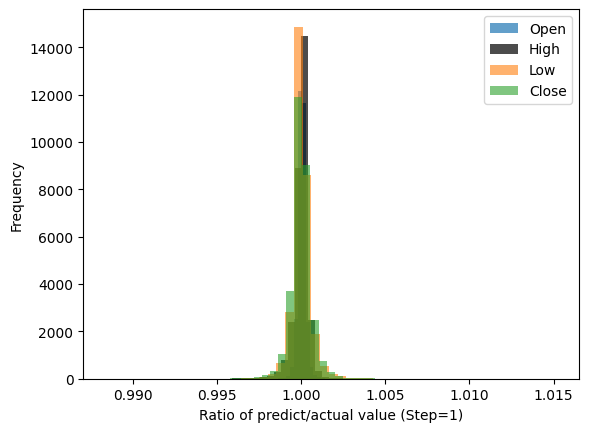

In [22]:
step=1
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

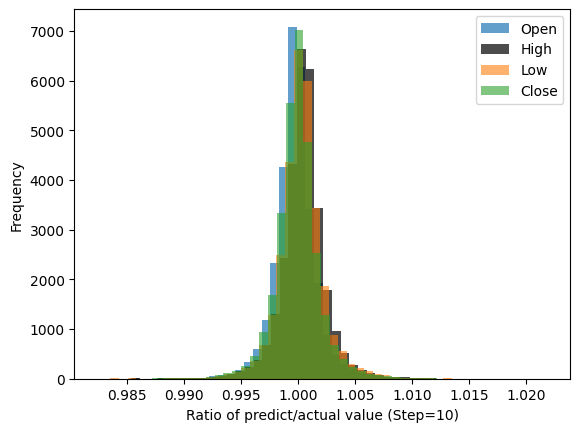

In [23]:
step=10
plt.hist(ohlc_pre[step, :, 0]/ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1]/ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2]/ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3]/ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Ratio of predict/actual value (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

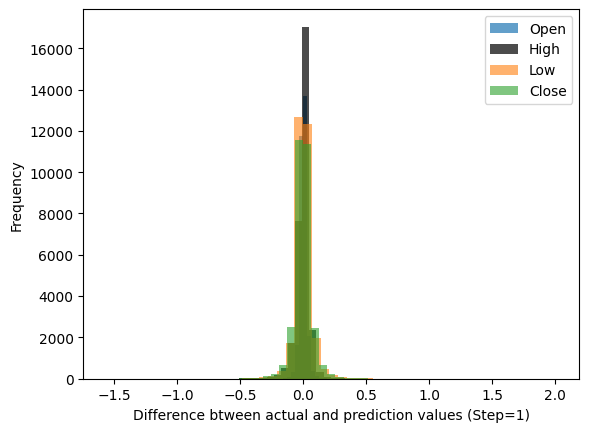

In [24]:
step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

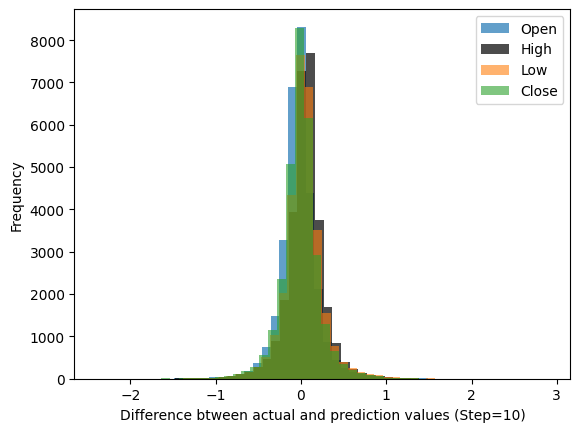

In [25]:
step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [26]:
np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [ 0.       0.0021   0.00262 -0.00063 -0.00394 -0.00751 -0.01121 -0.01501
 -0.01888 -0.02279 -0.02674]
High [ 0.      -0.00025  0.00759  0.01371  0.0198   0.0257   0.03151  0.03725
  0.04292  0.04853  0.05409]
Low [0.      0.00077 0.00426 0.00741 0.01055 0.01365 0.01673 0.01981 0.02287
 0.02592 0.02895]
Close [ 0.      -0.00074 -0.00146 -0.00218 -0.00291 -0.00364 -0.00438 -0.00511
 -0.00585 -0.00659 -0.00735]
==============Var============
Open [0.      0.00082 0.00659 0.01222 0.01811 0.02379 0.02965 0.03556 0.04167
 0.04785 0.05397]
High [0.      0.00345 0.00934 0.01528 0.02114 0.02703 0.03302 0.03905 0.0452
 0.05135 0.05741]
Low [0.      0.0051  0.01141 0.01765 0.02362 0.02957 0.03564 0.04182 0.04811
 0.05438 0.06055]
Close [0.      0.00593 0.01163 0.01755 0.02327 0.02918 0.0351  0.04124 0.04741
 0.05356 0.05973]


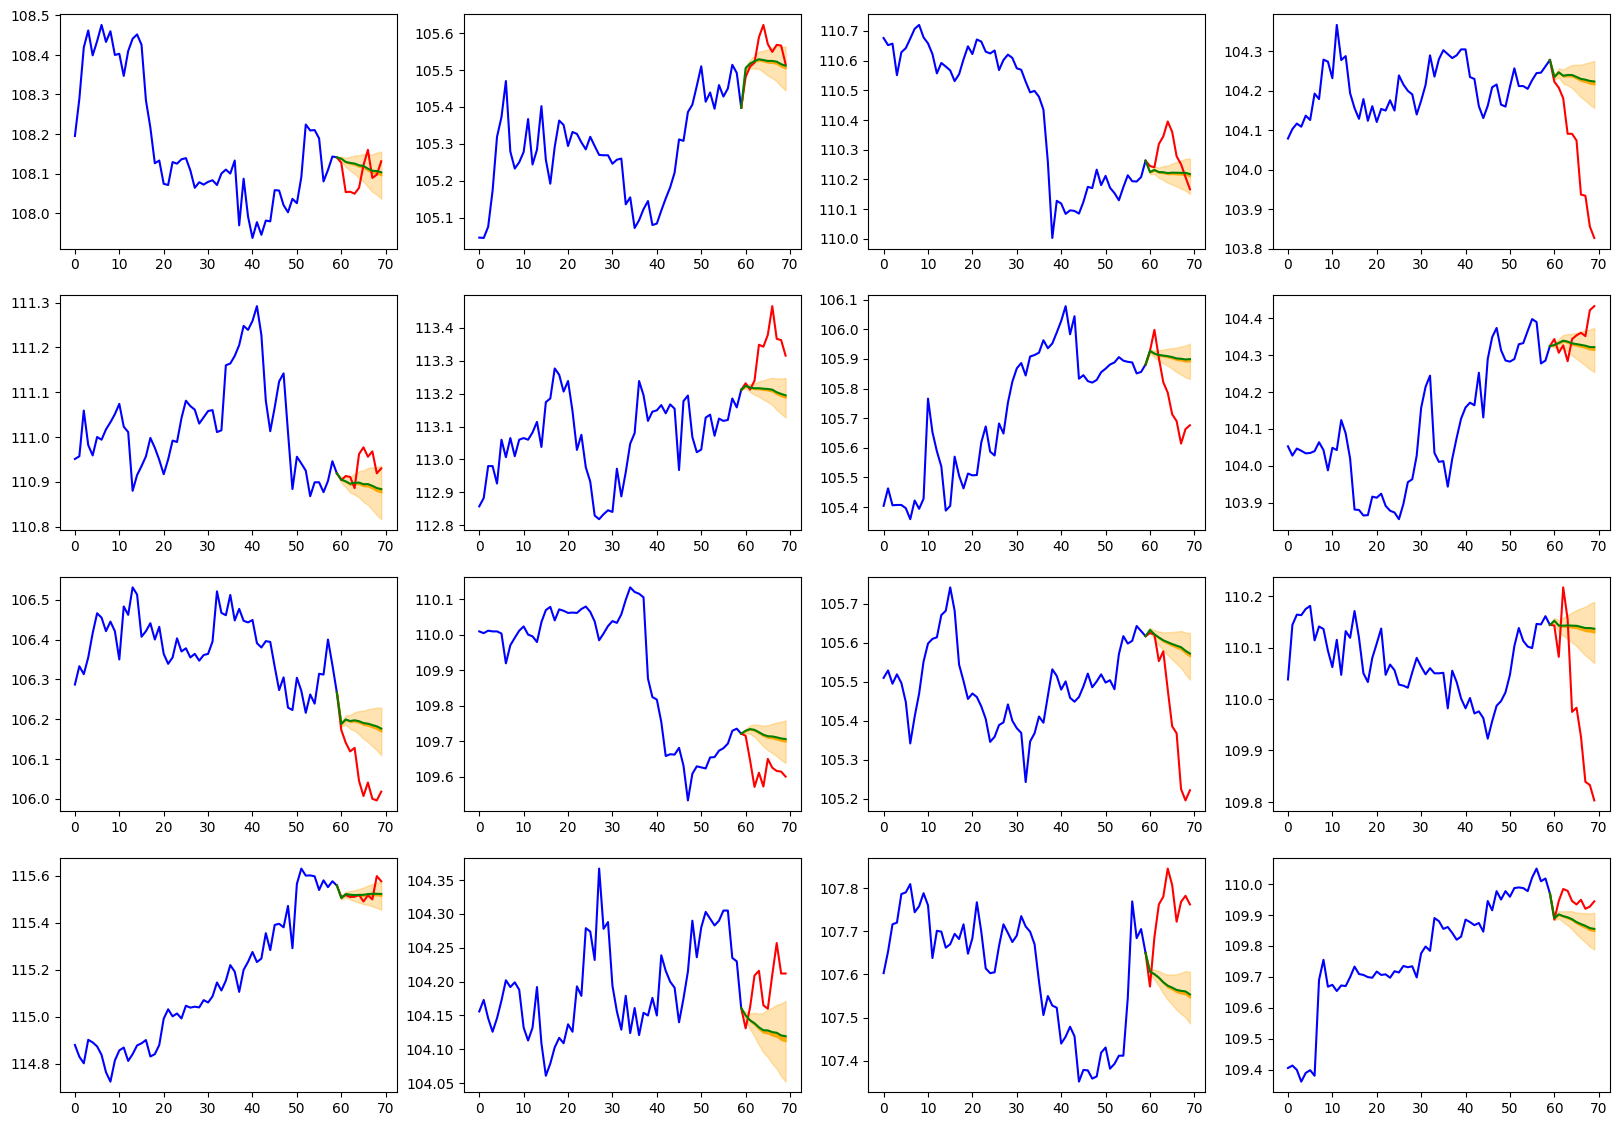

In [27]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)
close_var = np.var(ohlc_pre[:, :, 3]-ohlc_ans[:, :, 3], axis=1)

total_length = observation_length + prediction_length
x = np.arange(total_length)



for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i)
    original_ohlc = df[ohlc_column[0]].iloc[index: index + observation_length]
    pred_value = ohlc_pre[:, i, 0]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    ax.fill_between(x[observation_length-1:], pred_value, pred_add_mean, color="orange", alpha=0.9)
    ax.fill_between(x[observation_length-1:], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length-1:], ohlc_ans[:, i, 0], color="red")
    ax.plot(x[observation_length-1:], pred_value, color="green")
plt.show()

## Increase feature dims

In [31]:
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import (TransformerDecoder, TransformerDecoderLayer,
                      TransformerEncoder, TransformerEncoderLayer)
from torch.utils.data import DataLoader
from tqdm import tqdm

In [ ]:
import sys

module_path = os.path.abspath("../..")
sys.path.append(module_path)

from Dataset.transformer import TimeFeatureDataset
from fprocess import fprocess

### Add volume and spread

In [29]:
import os
import pandas as pd


ohlc_column = ['open','high','low','close']
additional_columns = ["tick_volume", "spread"]
file_path = os.path.abspath('../Data/mt5_USDJPY_min30.csv')
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

#### Define Model

Same as previous model

In [32]:
class PositionalEncoding(nn.Module):
    def __init__(self, time_size, d_model):
        super().__init__()
        self.pe = nn.Embedding(time_size, d_model)

    def forward(self,time_ids):
        position = self.pe(time_ids)
        return position

In [33]:
class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        feature_size: int, time_size:int =  24*7*2,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.positional_encoding = PositionalEncoding(time_size=time_size, d_model=feature_size)
        
        encoder_layer = TransformerEncoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        decoder_layer = TransformerDecoderLayer(
            d_model=feature_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

    def forward(
        self,
        src: Tensor, src_time: Tensor,
        tgt: Tensor, tgt_time: Tensor,
        mask_tgt: Tensor, mask_src: Tensor=None, padding_mask_src: Tensor=None, padding_mask_tgt: Tensor=None,
        memory_key_padding_mask: Tensor=None
    ):
        
        src_time = self.positional_encoding(src_time)
        src = torch.add(src, src_time)
        tgt_time = self.positional_encoding(tgt_time)
        tgt = torch.add(tgt, tgt_time)
        memory = self.transformer_encoder(src, mask_src, padding_mask_src)
        outs = self.transformer_decoder(
            tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return outs

In [34]:
def train(model, ds, optimizer, criterion, batch_size, device):
    
    model.train()
    ds.train()
    losses = 0
    
    length = 0.0
    end_index = len(ds)
    for index in tqdm(range(0, end_index, batch_size)):
        if end_index - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt
        
        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )

        optimizer.zero_grad()

        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / length

In [35]:
def evaluate(model, ds, criterion, batch_size, device):
    
    model.eval()
    ds.eval()
    losses = 0
    length = 0.0
    for index in range(0, len(ds), batch_size):
        if len(ds) - index < batch_size:
            break
        length+=1.0
        src, tgt = ds[index:index+batch_size]
        src, src_time = src
        tgt, tgt_time = tgt
        
        input_tgt_time = tgt_time[:-1, :]
        input_tgt = tgt[:-1, :]

        mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
        logits = model(
            src=src, src_time=src_time,
            tgt=input_tgt, tgt_time=input_tgt_time,
            mask_tgt=mask_tgt
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits, output_tgt)
        losses += loss.item()
        
    return losses / length

#### Traininig

In [36]:
columns = ohlc_column+additional_columns

log_p = fprocess.LogPreProcess(columns=columns)
diff_p = fprocess.DiffPreProcess(columns=columns)
time_p = fprocess.WeeklyIDProcess(freq= 30, time_column= "index")
ohlc_pre_process = [log_p, diff_p, time_p]

standalization_p = fprocess.MinMaxPreProcess(columns=columns)
processes = [*ohlc_pre_process, standalization_p]

In [41]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_name = "finance_basic_wt_transfomer"
model_version = "2"

#Dataset parameters
batch_size = 64
observation_length = 30
prediction_length = 10

ds = TimeFeatureDataset(df, columns, time_column="index",
                        processes=processes, observation_length=observation_length,
                        prediction_length=prediction_length)

In [38]:
# # check outputs represent (data_length, chunk_size, feature_size)
# ds.train()
# for index in range(0, len(ds)-16, 16):
#     src, tgt = ds[index: index+16]
#     break
# print(src[0].shape, src[1].shape) 
# print(tgt[0].shape, tgt[1].shape)

torch.Size([30, 16, 6]) torch.Size([30, 16])
torch.Size([11, 16, 6]) torch.Size([11, 16])


In [39]:
feature_size = 6
freq=30

# Hyper parameters
nhead = 2
dim_feedforward = 1000
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.01


model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    feature_size=feature_size,
    time_size=24*7*(60//freq),
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

In [40]:
lr = 0.00005

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.95)

In [ ]:
epoch = 500
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, ds=ds, optimizer=optimizer,
        criterion=criterion, batch_size=batch_size,
        device=device
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, ds=ds, criterion=criterion,
        batch_size=batch_size, device=device
    )
    
    print('[{}/{}] train loss: {:.10f}, valid loss: {:.10f}  [{}{:.0f}s] count: {}, {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
    else:
        counter += 1
        scheduler.step()
        
    if counter > patience:
        break

## Data Argument

Even if we increase/descrease the model size, model usually overfit to train data. Try to resolve that by increarsing the data.

Try to train the model with argmented df

### Simply Add the data range

Above result caliculated with date from 2014 to 2022. This is a bit short to learn. We can get longer data from Ducascopy, HistData etc.

In [5]:
import glob
import os

folder_path = os.path.abspath('L:/data/fx/HistData/USDJPY')
files = glob.glob(folder_path + '/DAT_ASCII_USDJPY_M1_*.zip')
files

['L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2000.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2001.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2002.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2003.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2004.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2005.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2006.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2007.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2008.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2009.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2010.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2011.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2012.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2013.zip',
 'L:\\data\\fx\\HistData\\USDJPY\\DAT_ASCII_USDJPY_M1_2014.zip',
 'L:\\data\\fx\\HistData\

In [32]:
import zipfile
import os

import pandas as pd

def read_histdata_file(file):
    basename = os.path.basename(file).split('.')[0]
    with zipfile.ZipFile(file, "r") as zip_ref:
        with zip_ref.open(f'{basename}.csv') as fp:
            df = pd.read_csv(fp, sep=';', header=None, date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d %H%M%S'), index_col=0,  parse_dates=True)
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    df.index.name = "time"
    return df

In [51]:
import pandas as pd
from tqdm import tqdm

df = pd.DataFrame()
ohlc_column = ['open', 'high', 'low', 'close']
volume_column = "volume"

for file in tqdm(files):
    min_df = read_histdata_file(file)
    rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq="30MIN")).first()
    rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq="30MIN")).max()
    rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq="30MIN")).min()
    rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq="30MIN")).last()
    rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq="30MIN")).sum()
    rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
    rolled_df.dropna(inplace=True)
    df = pd.concat([df, rolled_df], axis=0)

 40%|████      | 4/10 [04:59<07:55, 79.25s/it]

In [3]:
df.columns = ["open", "high", "low", "close", "tick_volume"]
df

,open,high,low,close,tick_volume
Gmt time,,,,,
2004-01-01 00:00:00,107.400,107.410,107.400,107.410,3.00
2004-01-01 01:30:00,107.200,107.280,107.200,107.280,4.00
2004-01-01 02:30:00,107.280,107.280,107.260,107.260,1.00
2004-01-01 03:00:00,107.260,107.260,107.200,107.260,8.00
2004-01-01 03:30:00,107.200,107.260,107.200,107.260,5.00
...,...,...,...,...,...
2022-12-30 19:30:00,130.952,131.020,130.925,130.971,12328.22
2022-12-30 20:00:00,130.969,131.132,130.969,131.051,4763.65
2022-12-30 20:30:00,131.050,131.291,130.996,131.269,5169.85


In [4]:
df.to_csv("../../Data/Dukascopy_USDJPY_30min.csv")

In [1]:
import pandas as pd

df = pd.read_csv("../../Data/Dukascopy_USDJPY_30min.csv", index_col=0, parse_dates=True)

#### Verify the results

best loss:  0.0003073257

epoc count: 30

[19/500] train loss: 0.0004026587, valid loss: 0.0003073257  [32m35s] count: 1, **

params:

- feature_size = 4
- freq=30
- nhead = 1
- dim_feedforward = 1000
- num_encoder_layers = 6
- num_decoder_layers = 6
- dropout = 0.001

training again as data was strange

In [13]:
model_version = 2
print(f"loading {model_name}_v{model_version}")
model.load_state_dict(torch.load(f'./{model_name}_v{model_version}.torch'))

loading finance_basic_wt_transfomer_v2


<All keys matched successfully>

In [14]:
def prediction(inputs, tgt_time_org):
    inputs, src_time = inputs
    preds = torch.zeros(1, inputs.size(1), feature_size, device=device)
    preds[0, :, :] = inputs[-1,:, :]
    # instead of caliculate next tick time, use tgt_time provided by dataset
    tgt_time = tgt_time_org[:1, :]
    while preds.size(0) <= prediction_length:
        current_length = preds.size(0)
        tgt_time = tgt_time_org[:current_length, :]
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(preds.size(0)).to(device)
        out = model(src=inputs, src_time=src_time,
                    tgt=preds, tgt_time=tgt_time,
                    mask_tgt=tgt_mask)
        preds = torch.cat([preds, out[-1:]], dim=0)
    return preds

[]

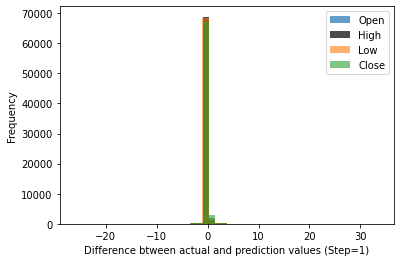

In [37]:
step=1
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step-1, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step-1, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step-1, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step-1, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

[]

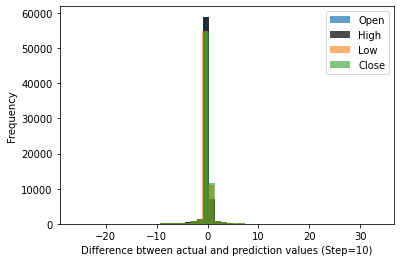

In [26]:
step=10
plt.hist(ohlc_pre[step, :, 0] - ohlc_ans[step-1, :, 0], bins=50, alpha=0.7)
plt.hist(ohlc_pre[step, :, 1] - ohlc_ans[step-1, :, 1], bins=50, alpha=0.7, color="black")
plt.hist(ohlc_pre[step, :, 2] - ohlc_ans[step-1, :, 2], bins=50, alpha=0.6)
plt.hist(ohlc_pre[step, :, 3] - ohlc_ans[step-1, :, 3], bins=50, alpha=0.6)
plt.xlabel(f'Difference btween actual and prediction values (Step={step})')
plt.ylabel('Frequency')
plt.legend(['Open', 'High', "Low", "Close"])
plt.plot()

In [23]:
np.set_printoptions(precision=5)

print("==============Mean============")
print("Open", np.mean(ohlc_pre[1:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.mean(ohlc_pre[1:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.mean(ohlc_pre[1:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.mean(ohlc_pre[1:, :, 3]-ohlc_ans[:, :, 3], axis=1))

print("==============Var============")
print("Open", np.var(ohlc_pre[1:, :, 0]-ohlc_ans[:, :, 0], axis=1))
print("High", np.var(ohlc_pre[1:, :, 1]-ohlc_ans[:, :, 1], axis=1))
print("Low", np.var(ohlc_pre[1:, :, 2]-ohlc_ans[:, :, 2], axis=1))
print("Close", np.var(ohlc_pre[1:, :, 3]-ohlc_ans[:, :, 3], axis=1))

==============Mean============
Open [ 0.00076 -0.0004  -0.00155 -0.00271 -0.00386 -0.00501 -0.00616 -0.00731
 -0.00847 -0.00963]
High [-0.00264 -0.00702 -0.01127 -0.01545 -0.01961 -0.02378 -0.02798 -0.03216
 -0.03633 -0.04048]
Low [-0.03658 -0.03533 -0.0342  -0.03315 -0.03211 -0.03106 -0.02999 -0.02893
 -0.02789 -0.02687]
Close [0.04041 0.03908 0.03776 0.03644 0.03512 0.03379 0.03247 0.03114 0.02981
 0.02849]
==============Var============
Open [0.37847 0.58009 0.78069 0.98019 1.18393 1.38471 1.5907  1.79607 2.00232
 2.20724]
High [0.37491 0.57701 0.77658 0.97628 1.17942 1.37996 1.58583 1.79176 1.99787
 2.20325]
Low [0.37586 0.57704 0.77916 0.97865 1.1821  1.38186 1.58606 1.79024 1.99324
 2.19675]
Close [0.37756 0.57796 0.77988 0.98096 1.18514 1.38705 1.59476 1.80273 2.01012
 2.21869]


In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 14))
close_mean = np.mean(ohlc_pre[1:, :, 3]-ohlc_ans[:, :, 3], axis=1)
close_var = np.var(ohlc_pre[1:, :, 3]-ohlc_ans[:, :, 3], axis=1)

total_length = observation_length + prediction_length
x = np.arange(total_length)



for i, ax in enumerate(axs.flat):
    index = ds.get_actual_index(i)
    original_ohlc = df[ohlc_column[0]].iloc[index: index + observation_length]
    pred_value = ohlc_pre[1:, i, 0]
    pred_add_mean = pred_value + close_mean
    pred_upper = pred_add_mean + close_var
    pred_lower = pred_add_mean - close_var

    # ax.fill_between(x[observation_length :], pred_value, pred_add_mean, color="orange", alpha=0.9)
    # ax.fill_between(x[observation_length :], pred_lower, pred_upper, color="orange", alpha=0.3)
    ax.plot(x[:observation_length], original_ohlc, color="blue")
    ax.plot(x[observation_length:], ohlc_ans[:, i, 0], color="red")
    ax.plot(x[observation_length:], pred_value, color="green")
plt.show()

### Shift Rolling

In [ ]:
import pandas as pd
from tqdm import tqdm

df = pd.DataFrame()
ohlc_column = ['Open', 'High', 'Low', 'Close']
volume_column = "Volume"

for file in files:
    min_df = pd.read_csv(file, index_col=0, parse_dates=True)
    df = pd.concat([df, min_df], axis=0)

In [ ]:
freq = 30
freq_str = "30MIN"

DFS = []

for bias in range(0, freq):
    min_df = df.copy()
    min_df.index += pd.Timedelta(minutes=bias)
    rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq=freq_str)).first().dropna()
    rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq=freq_str)).max().dropna()
    rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq=freq_str)).min().dropna()
    rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq=freq_str)).last().dropna()
    rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq=freq_str)).sum().dropna()
    rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
    DFS.append(rolled_df.iloc[1:-1])

In [ ]:
def train(model, ds_array, optimizer, criterion, batch_size, device):
    
    model.train()
    losses = 0
    length = 0.0
    for ds in ds_array:
        ds.train()
        end_index = len(ds)
        for index in tqdm(range(0, end_index - batch_size, batch_size)):
            length+=1.0
            src, tgt = ds[index:index+batch_size]
            src, src_time = src
            tgt, tgt_time = tgt
            
            input_tgt_time = tgt_time[:-1, :]
            input_tgt = tgt[:-1, :]

            mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
            logits = model(
                src=src, src_time=src_time,
                tgt=input_tgt, tgt_time=input_tgt_time,
                mask_tgt=mask_tgt
            )

            optimizer.zero_grad()

            output_tgt = tgt[1:, :]
            loss = criterion(logits, output_tgt)
            loss.backward()

            optimizer.step()
            losses += loss.item()
            
    return losses / length

In [ ]:
def evaluate(model, ds_array, criterion, batch_size, device):
    
    model.eval()
    losses = 0
    length = 0.0
    for ds in ds_array:
        ds.eval()
        for index in range(0, len(ds)-batch_size, batch_size):
            length+=1.0
            src, tgt = ds[index:index+batch_size]
            src, src_time = src
            tgt, tgt_time = tgt
            
            input_tgt_time = tgt_time[:-1, :]
            input_tgt = tgt[:-1, :]

            mask_tgt = nn.Transformer.generate_square_subsequent_mask(input_tgt.size(0)).to(device)
            logits = model(
                src=src, src_time=src_time,
                tgt=input_tgt, tgt_time=input_tgt_time,
                mask_tgt=mask_tgt
            )
            
            output_tgt = tgt[1:, :]
            loss = criterion(logits, output_tgt)
            losses += loss.item()
            
    return losses / length

### Use another Symbol

In [ ]:
import glob
import os

folder_path = os.path.abspath('L:/data/fx/Dukascopy')
# folders = glob.glob(folder_path + '/*JPY')
folders = [folder_path + '/USDJPY', folder_path + '/AUDJPY', folder_path + '/CHFJPY', folder_path + '/EURJPY']

In [ ]:
import pandas as pd
from tqdm import tqdm

df = pd.DataFrame()
ohlc_column = ['Open', 'High', 'Low', 'Close']
volume_column = "Volume"
DFS = []

for folder in folders:
    files = glob.glob(folder + '/*.csv')
    for file in tqdm(files):
        min_df = pd.read_csv(file, index_col=0, parse_dates=True)
        rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq="30MIN")).first()
        rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq="30MIN")).max()
        rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq="30MIN")).min()
        rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq="30MIN")).last()
        rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq="30MIN")).sum()
        rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
        rolled_df.dropna(inplace=True)
        df = pd.concat([df, rolled_df], axis=0)
        DFS.append(df)

### Apply All Ideas

## Add Symbols Features

In [ ]:
import glob
import os

import pandas as pd
from tqdm import tqdm


folder_path = os.path.abspath('L:/data/fx/Dukascopy')
symbols = ['USDJPY', 'AUDUSD', 'AUDJPY', 'CHFJPY', 'USDCHF' 'EURUSD', 'EURJPY', 'GBPUSD', 'GBPJPY']

df = pd.DataFrame()
ohlc_column = ['Open', 'High', 'Low', 'Close']
volume_column = "Volume"
DFS = {}

for symbol in symbols:
    files = glob.glob(folder + f'/{symbol}' +'/*.csv')
    for file in tqdm(files):
        min_df = pd.read_csv(file, index_col=0, parse_dates=True)
        rolled_open = min_df[ohlc_column[0]].groupby(pd.Grouper(level=0, freq="30MIN")).first()
        rolled_high = min_df[ohlc_column[1]].groupby(pd.Grouper(level=0, freq="30MIN")).max()
        rolled_min = min_df[ohlc_column[2]].groupby(pd.Grouper(level=0, freq="30MIN")).min()
        rolled_close = min_df[ohlc_column[3]].groupby(pd.Grouper(level=0, freq="30MIN")).last()
        rolled_volume = min_df[volume_column].groupby(pd.Grouper(level=0, freq="30MIN")).sum()
        rolled_df = pd.concat([rolled_open, rolled_high, rolled_min, rolled_close, rolled_volume], axis=1)
        rolled_df.dropna(inplace=True)
        df = pd.concat([df, rolled_df], axis=0)
    DFS[symbol] = df
df = pd.concat(DFS.values(), keys=DFS.keys() , axis=1).dropna()
df.columns = df.columns.swaplevel(0, 1)

## Add indicaters